## Import data, set logging level

In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np

## Reading Epochs and preprocessing

In [ ]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs.pick_types(meg='grad')
epochs.apply_baseline((None, 0))
epochs.crop(0, None)

## Create a dataset containig epoched data

In [ ]:
dataset = EpochsDataset(epochs, savepath='../dataset', transform = zscore)
del raw, epochs, epochs_list

## Save the dataset

In [ ]:
dataset.save('../data/dataset.pt')

## Read the dataset

In [2]:
dataset = read_epochs_dataset('../data/dataset.pt')

## Split the dataset into train and test sets

In [3]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [4]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

## Create a model, inheriting from the BaseModel class.
This model has a spatial filtering layer with a choice of each n-th output and a fully connected layer for predicting

In [5]:
class TimeCompNet(BaseModel):
    """
    A compact convolutional neural network implementing spatial decomposition of entire signals, temporal filtering and temporal compression of each component.

    Args:
        n_channels (int): Number of channels in the input data. Input data shape supposed to be: (N batches, N channels, N times).
        n_latent (int): Number of latent features in the unmixing layer.
        n_times (int): Length of the time axis of the input data.
        filter_size (int): Size of the FIR filters in the temporal convolutional layer.
        pool_factor (int): Factor to reduce the length of the time axis by selecting every n-th output.
        n_outputs (int): Number of outputs of the final fully connected layer.

    Attributes:
        pool_factor (int): Factor to reduce the length of the time axis by selecting every n-th output.
        unmixing_layer (nn.Module): 1D depthwise convolutional layer for spatial unmixing (filtering) the input tensor.
        temp_conv (nn.Module): 1D temporal convolutional layer for temporal filtering (FIR-filter-like) the spatially filtered tensor.
        fc_layer (nn.Module): Final fully connected layer for producing the outputs.

    """

    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.timesel_list = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n_times, (n_times//pool_factor+1)),
                nn.Dropout(.25),
                torch.nn.Sigmoid()
            )
            for _ in range(n_latent)
        ])
        final_out_features = (n_times//pool_factor+1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, n_channels, n_times).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, n_outputs).
        """
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timesel_list)
            ],
            1
        )
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

In [422]:
X, y = next(iter(DataLoader(train)))

In [424]:
TimeCompNet(204, 8, 301, 50, 10, 8).state_dict().keys()

odict_keys(['unmixing_layer.weight', 'unmixing_layer.bias', 'temp_conv.weight', 'temp_conv.bias', 'timesel_list.0.weight', 'timesel_list.0.bias', 'timesel_list.1.weight', 'timesel_list.1.bias', 'timesel_list.2.weight', 'timesel_list.2.bias', 'timesel_list.3.weight', 'timesel_list.3.bias', 'timesel_list.4.weight', 'timesel_list.4.bias', 'timesel_list.5.weight', 'timesel_list.5.bias', 'timesel_list.6.weight', 'timesel_list.6.bias', 'timesel_list.7.weight', 'timesel_list.7.bias', 'fc_layer.weight', 'fc_layer.bias'])

## Compile the model

In [6]:
model = TimeCompNet(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
                *[f'timesel_list.{i}.0.weight' for i in range(8)],
            ], lambdas=[.01, .01, *[1e-3 for _ in range(8)]]
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

odict_keys(['unmixing_layer.weight', 'unmixing_layer.bias', 'temp_conv.weight', 'temp_conv.bias', 'timesel_list.0.0.weight', 'timesel_list.0.0.bias', 'timesel_list.1.0.weight', 'timesel_list.1.0.bias', 'timesel_list.2.0.weight', 'timesel_list.2.0.bias', 'timesel_list.3.0.weight', 'timesel_list.3.0.bias', 'timesel_list.4.0.weight', 'timesel_list.4.0.bias', 'timesel_list.5.0.weight', 'timesel_list.5.0.bias', 'timesel_list.6.0.weight', 'timesel_list.6.0.bias', 'timesel_list.7.0.weight', 'timesel_list.7.0.bias', 'fc_layer.weight', 'fc_layer.bias'])

## Training the model

  0%|          | 0/150 [00:00<?, ?it/s]

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 0:  loss_train:  0.7823   |    binary_accuracy_train:  0.4110   |    loss_val:  0.7306   |    binary_accuracy_val:  0.6388
Epoch 1:  loss_train:  0.7296   |    binary_accuracy_train:  0.6400   |    loss_val:  0.6833   |    binary_accuracy_val:  0.7611
Epoch 2:  loss_train:  0.6823   |    binary_accuracy_train:  0.7569   |    loss_val:  0.6406   |    binary_accuracy_val:  0.7967
Epoch 3:  loss_train:  0.6394   |    binary_accuracy_train:  0.8067   |    loss_val:  0.6024   |    binary_accuracy_val:  0.8750
Epoch 4:  loss_train:  0.6011   |    binary_accuracy_train:  0.8750   |    loss_val:  0.5689   |    binary_accuracy_val:  0.8750
Epoch 5:  loss_train:  0.5668   |    binary_accuracy_train:  0.8750   |    loss_val:  0.5398   |    binary_accuracy_val:  0.8750
Epoch 6:  loss_train:  0.5379   |    binary_accuracy_train:  0.8750   |    loss_val:  0.5149   |    binary_accuracy_val:  0.8750
Epoch 7:  loss_train:  0.5131   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4941   | 

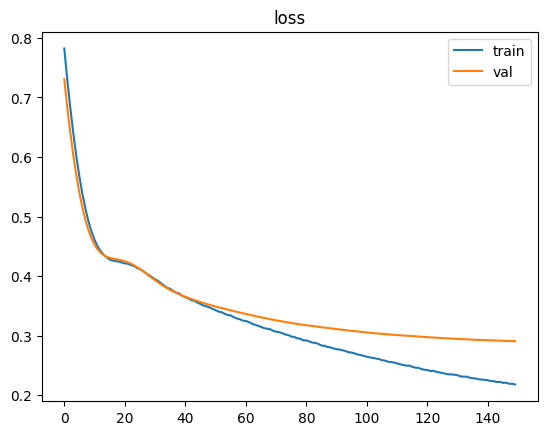

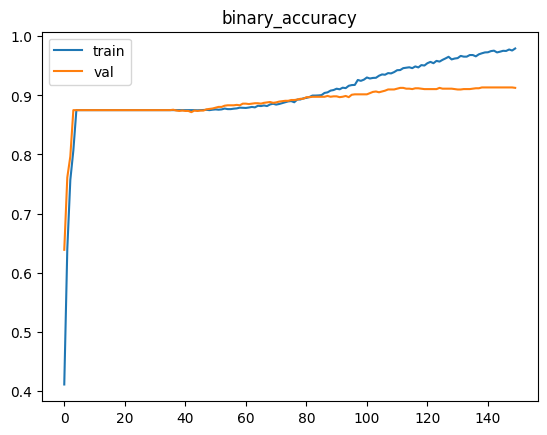

In [7]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60, update_every_n_batches=10)
plot_metrics(history)

## Evaluate the model

In [9]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.21782939677888696
train_binary_accuracy: 0.9651660810817372
loss: 0.30264914577657526
binary_accuracy: 0.9172077991745688


## Make prediction

#### Take a random sample from the test set

In [10]:
i = np.random.randint(len(test))
print(f'Sample {i}')
x, y = test[i]
y = y.numpy()

# unsqueezing due to the first dimension must be batch size
x = torch.unsqueeze(x, 0)

Sample 31


#### Make a prediction, print the predicted value and the actual label

In [11]:
y_pred = np.round(torch.squeeze(model(x)).detach().numpy(), 2)

print(f'Prediction: {" | ".join([str(sample).center(5, " ") for sample in y_pred])}')
print(f'Actual:     {" | ".join([str(sample).center(5, " ") for sample in y])}')

Prediction: -3.27 | -2.32 |  -4.3 | -3.64 | -3.48 |  1.14 | -3.51 | -3.97
Actual:      0.0  |  0.0  |  0.0  |  0.0  |  0.0  |  1.0  |  0.0  |  0.0 


Processing branch 0/7  56.825 s


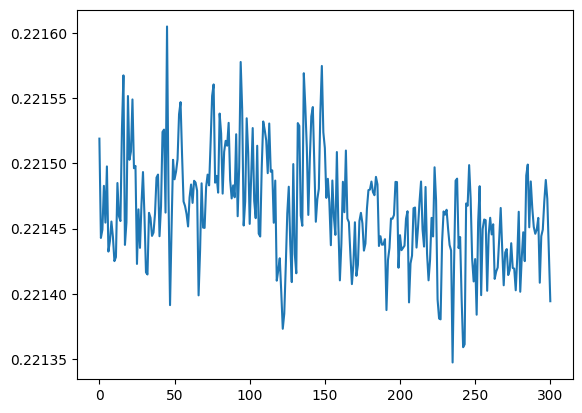

Processing branch 1/7  58.000 s


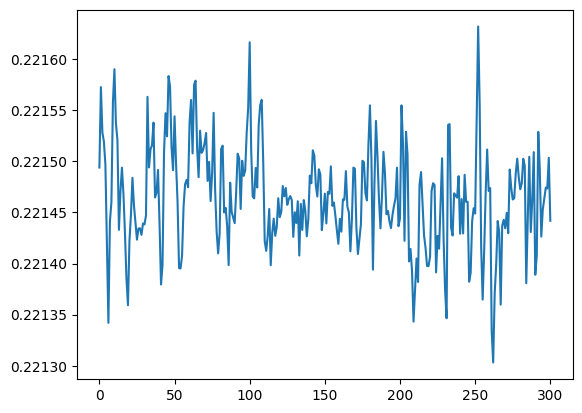

Processing branch 2/7  58.679 s


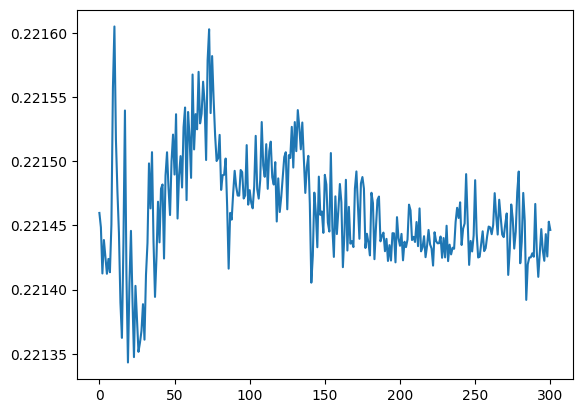

Processing branch 3/7  60.816 s


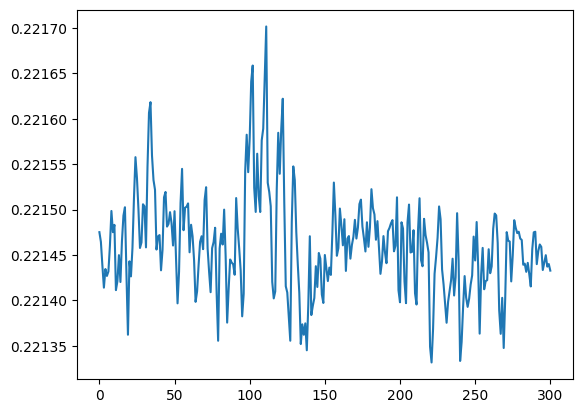

Processing branch 4/7  60.594 s


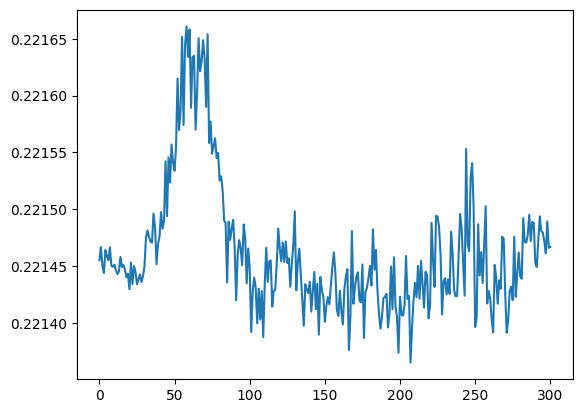

Processing branch 5/7  60.566 s


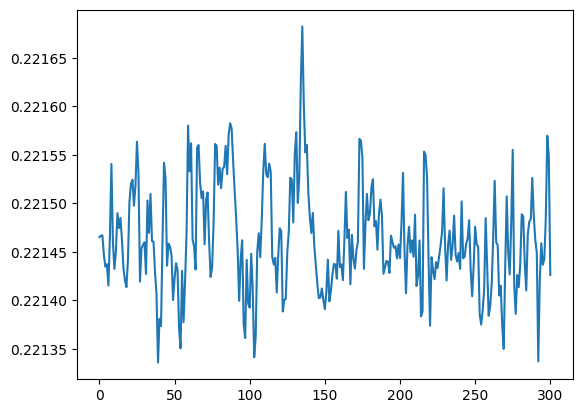

Processing branch 6/7  59.214 s


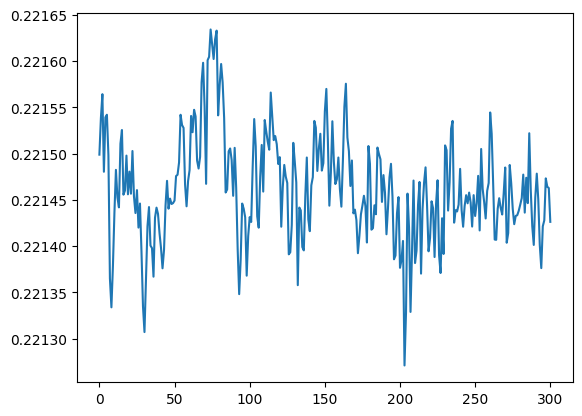

Processing branch 7/7  59.183 s


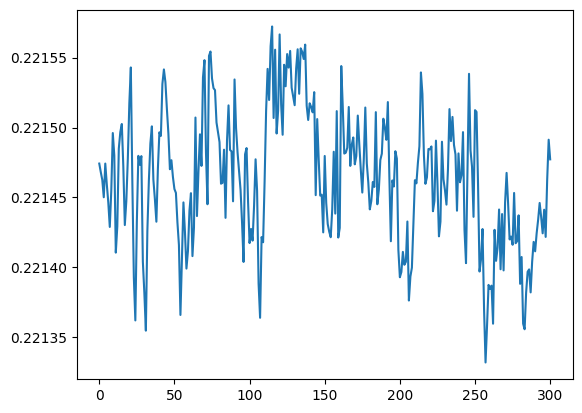

In [64]:
from copy import deepcopy
import time
with torch.no_grad():
    loader = DataLoader(test, len(test))
    base_loss = model.evaluate(loader)['loss']
    n_latent = model.unmixing_layer.weight.shape[0]
    X, y = next(iter(loader))
    losses = list()
    temp_conv_output = model.temp_conv(model.unmixing_layer(X))
    n_times = temp_conv_output.shape[-1]
    branchwise = list()
    # unmixing_weights_original = deepcopy(model.unmixing_layer.weight)
    # unmixing_bias_original = deepcopy(model.unmixing_layer.bias)
    # temp_conv_bias_original = deepcopy(model.temp_conv.bias)
    for i in range(n_latent):
        print(f'Processing branch {i}/{n_latent-1}', end=' ')
        t = time.time()
        # if i == 0:
        #     model.unmixing_layer.weight[1:, :, :] = 0
        #     model.unmixing_layer.bias[1:] = 0
        #     temp_conv_bias_original[1:] = 0
        # elif i == n_latent - 1:
        #     model.unmixing_layer.weight[:-1, :, :] = 0
        #     model.unmixing_layer.bias[:-1] = 0
        #     temp_conv_bias_original[:-1] = 0
        # else:
        #     model.unmixing_layer.weight[:i, :, :] = 0
        #     model.unmixing_layer.weight[i+1:, :, :] = 0
        #     model.unmixing_layer.bias[:i] = 0
        #     model.unmixing_layer.bias[i+1:] = 0
        #     temp_conv_bias_original[:i] = 0
        #     temp_conv_bias_original[i+1:] = 0
        timesel = model.timesel_list[i]
        # timesel_weights_original = deepcopy(timesel[0].weight)
        tempwise = list()

        for j in range(n_times):
            timesel_timepoint_original = deepcopy(timesel[0].weight[:, j])
            timesel[0].weight[:, j] = 0
            tempwise.append(model.evaluate(loader)['loss'])
            timesel[0].weight[:, j] = timesel_timepoint_original

            # if j == 0:
            #     timesel[0].weight[:, 1:] = 0
            # elif j == n_times - 1:
            #     timesel[0].weight[:, :-1] = 0
            # else:
            #     timesel[0].weight[:, :j] = 0
            #     timesel[0].weight[:, j+1:] = 0

            # tempwise.append(model.evaluate(loader)['loss'])
            # timesel[0].weight = timesel_weights_original
        branchwise.append(tempwise)
        # model.unmixing_layer.weight = unmixing_weights_original
        # model.unmixing_layer.bias = unmixing_bias_original
        # model.temp_conv.bias = temp_conv_bias_original
        print(f'{(time.time() - t) : .3f} s')
        plt.plot(tempwise)
        plt.show()

    branchwise = np.array(branchwise)
# for i in range(n_latent):
#     branch_unmixing_weights_original = deepcopy(self.model.unmixing_layer.weight[i, :, :])
#     branch_unmixing_bias_original = deepcopy(self.model.unmixing_layer.bias[i])
#     branch_temp_conv_bias_original = deepcopy(self.model.temp_conv.bias[i])
#     self.model.unmixing_layer.weight[i, :, :] = 0
#     self.model.unmixing_layer.bias[i] = 0
#     self.model.temp_conv.bias[i] = 0
#     losses.append(self.model.evaluate(loader)['loss'])
#     self.model.unmixing_layer.weight[i, :, :] = branch_unmixing_weights_original
#     self.model.unmixing_layer.bias[i] = branch_unmixing_bias_original
#     self.model.temp_conv.bias[i] = branch_temp_conv_bias_original
# return base_loss - np.array(losses)

Processing branch 0/7  61.665 s


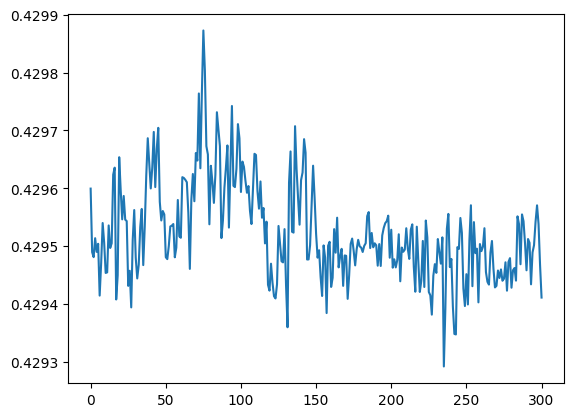

Processing branch 1/7  65.447 s


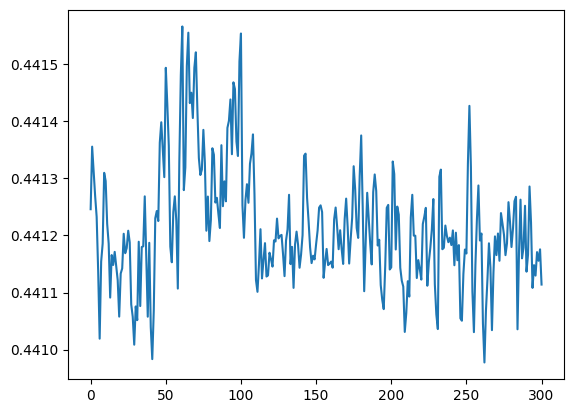

Processing branch 2/7  66.509 s


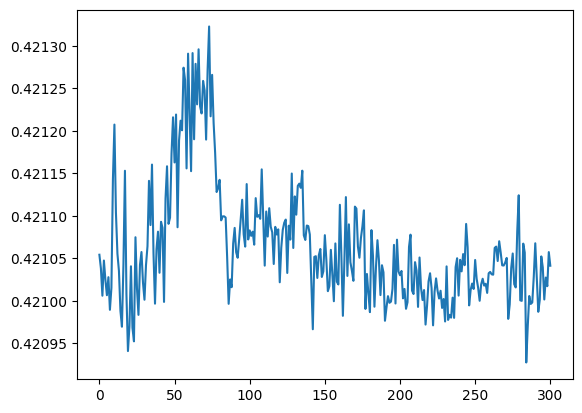

Processing branch 3/7  62.354 s


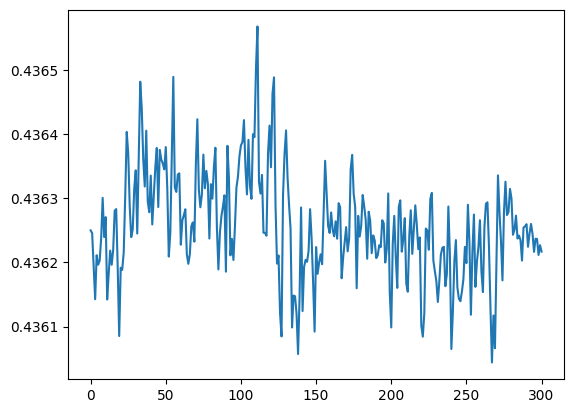

Processing branch 4/7  69.046 s


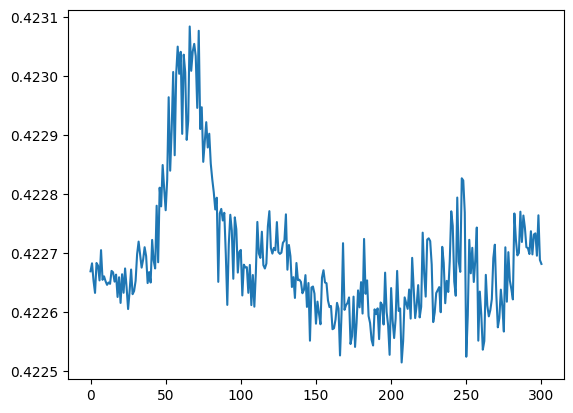

Processing branch 5/7  64.627 s


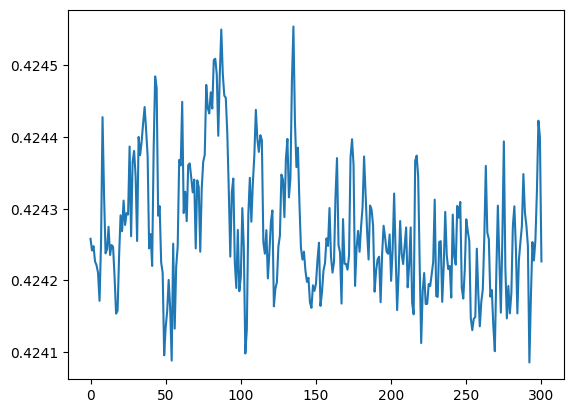

Processing branch 6/7  65.637 s


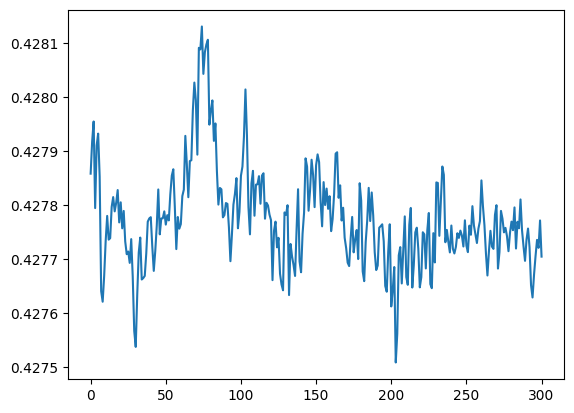

Processing branch 7/7  68.334 s


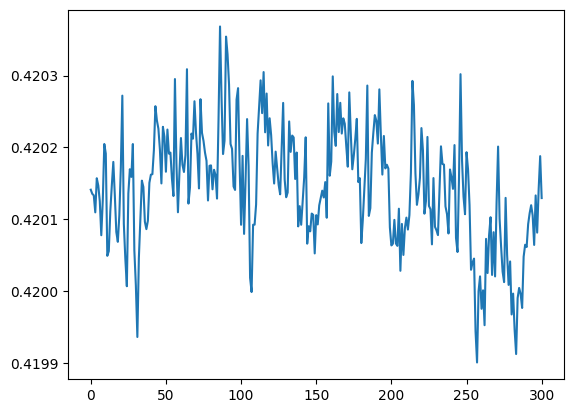

In [60]:
from copy import deepcopy
import time
with torch.no_grad():
    loader = DataLoader(test, len(test))
    base_loss = model.evaluate(loader)['loss']
    n_latent = model.unmixing_layer.weight.shape[0]
    X, y = next(iter(loader))
    losses = list()
    temp_conv_output = model.temp_conv(model.unmixing_layer(X))
    n_times = temp_conv_output.shape[-1]
    branchwise = list()
    unmixing_weights_original = deepcopy(model.unmixing_layer.weight)
    # unmixing_weights_original = unmixing_weights_original_.numpy()
    # unmixing_weights_original2 = deepcopy(unmixing_weights_original_)
    unmixing_bias_original = deepcopy(model.unmixing_layer.bias)
    # unmixing_bias_original = unmixing_bias_original_.numpy()
    # unmixing_bias_original2 = deepcopy(unmixing_bias_original_)
    temp_conv_bias_original = deepcopy(model.temp_conv.bias)
    # temp_conv_bias_original = temp_conv_bias_original_.numpy()
    # temp_conv_bias_original2 = deepcopy(temp_conv_bias_original_)
    # unmixing_weights_original = deepcopy(model.unmixing_layer.weight)
    # unmixing_bias_original = deepcopy(model.unmixing_layer.bias)
    # temp_conv_bias_original = deepcopy(model.temp_conv.bias)

    for i in range(n_latent):
        print(f'Processing branch {i}/{n_latent-1}', end=' ')
        # print('0b', unmixing_weights_original[i, 0])
        # print('0b2', unmixing_weights_original2[i, 0])
        # print('0a', model.unmixing_layer.weight[i, 0])
        t = time.time()
        if i == 0:
            model.unmixing_layer.weight[1:, :, :] = 0
            model.unmixing_layer.bias[1:] = 0
            model.temp_conv.bias[1:] = 0
        elif i == n_latent - 1:
            model.unmixing_layer.weight[:-1, :, :] = 0
            model.unmixing_layer.bias[:-1] = 0
            model.temp_conv.bias[:-1] = 0
        else:
            model.unmixing_layer.weight[:i, :, :] = 0
            model.unmixing_layer.weight[i+1:, :, :] = 0
            model.unmixing_layer.bias[:i] = 0
            model.unmixing_layer.bias[i+1:] = 0
            model.temp_conv.bias[:i] = 0
            model.temp_conv.bias[i+1:] = 0
        # print('b', unmixing_weights_original[i, 0])
        # print('b2', unmixing_weights_original2[i, 0])
        # print('a', model.unmixing_layer.weight[i, 0])
        timesel = model.timesel_list[i]
        # timesel_weights_original = deepcopy(timesel[0].weight)
        tempwise = list()

        for j in range(n_times):
            timesel_timepoint_original = deepcopy(timesel[0].weight[:, j])
            # timesel_timepoint_original = deepcopy(timesel[0].weight[:, j])
            timesel[0].weight[:, j] = 0
            tempwise.append(model.evaluate(loader)['loss'])
            timesel[0].weight[:, j] = timesel_timepoint_original

            # if j == 0:
            #     timesel[0].weight[:, 1:] = 0
            # elif j == n_times - 1:
            #     timesel[0].weight[:, :-1] = 0
            # else:
            #     timesel[0].weight[:, :j] = 0
            #     timesel[0].weight[:, j+1:] = 0

            # tempwise.append(model.evaluate(loader)['loss'])
            # timesel[0].weight = timesel_weights_original
        branchwise.append(tempwise)
        # model.load_state_dict(state_dict)
        # print('0c', model.unmixing_layer.weight[i, 0])
        # print('0c2', unmixing_weights_original2[i, 0])
        # print('0d', unmixing_weights_original[i, 0])
        model.unmixing_layer.weight[:, :, :] = unmixing_weights_original
        # model.unmixing_layer.weight[:, :, :] = torch.nn.Parameter(torch.Tensor(deepcopy(unmixing_weights_original)))
        # print('c', model.unmixing_layer.weight[i, 0])
        # print('c2', unmixing_weights_original2[i, 0])
        # print('d', unmixing_weights_original[i, 0])
        # model.unmixing_layer.bias[:] = torch.nn.Parameter(torch.Tensor(deepcopy(unmixing_bias_original)))
        model.unmixing_layer.bias[:] = unmixing_bias_original
        # model.temp_conv.bias[:] = torch.nn.Parameter(torch.Tensor(deepcopy(temp_conv_bias_original)))
        model.temp_conv.bias[:] = temp_conv_bias_original
        print(f'{(time.time() - t) : .3f} s')
        plt.plot(tempwise)
        plt.show()

    branchwise = np.array(branchwise)


In [12]:
import scipy as sp
from copy import deepcopy
from tqdm import tqdm
from deepmeg.utils.printout import nostdout
import matplotlib
from deepmeg.utils.viz import generate_cmap
from deepmeg.interpreters import LFCNNInterpreter


class TimeCompNetInterpreter(LFCNNInterpreter):
    """
        Initialize TimeCompNetInterpreter object.

        Parameters:
            model (TimeCompNet): Trained LFCNN model.
            dataset (Dataset): Data used to train the LFCNN model.
            info (mne.Info): Information about recordings, typically contained in the "info" property of the corresponding instance (E.g. epochs.info).
        """
    def __init__(self, model: TimeCompNet, dataset: Dataset, info: mne.Info):
        super().__init__(model, dataset, info)
        self._tempwise_loss = None

    @torch.no_grad()
    def compute_tempwise_loss(self):

        loader = DataLoader(self.dataset, len(self.dataset))
        n_latent = self.model.unmixing_layer.weight.shape[0]
        X, y = next(iter(loader))
        temp_conv_output = self.model.temp_conv(self.model.unmixing_layer(X))
        n_times = temp_conv_output.shape[-1]
        branchwise = list()
        unmixing_weights_original = deepcopy(model.unmixing_layer.weight)
        unmixing_bias_original = deepcopy(model.unmixing_layer.bias)
        temp_conv_bias_original = deepcopy(model.temp_conv.bias)

        for i in tqdm(range(n_latent), initial=1, total=n_latent, file=sys.stdout):
            with nostdout():
                if i == 0:
                    model.unmixing_layer.weight[1:, :, :] = 0
                    model.unmixing_layer.bias[1:] = 0
                    model.temp_conv.bias[1:] = 0
                elif i == n_latent - 1:
                    model.unmixing_layer.weight[:-1, :, :] = 0
                    model.unmixing_layer.bias[:-1] = 0
                    model.temp_conv.bias[:-1] = 0
                else:
                    model.unmixing_layer.weight[:i, :, :] = 0
                    model.unmixing_layer.weight[i+1:, :, :] = 0
                    model.unmixing_layer.bias[:i] = 0
                    model.unmixing_layer.bias[i+1:] = 0
                    model.temp_conv.bias[:i] = 0
                    model.temp_conv.bias[i+1:] = 0

                timesel = model.timesel_list[i]
                tempwise = list()

                for j in range(n_times):
                    timesel_timepoint_original = deepcopy(timesel[0].weight[:, j])
                    timesel[0].weight[:, j] = 0
                    tempwise.append(model.evaluate(loader)['loss'])
                    timesel[0].weight[:, j] = timesel_timepoint_original

                branchwise.append(tempwise)
                model.unmixing_layer.weight[:, :, :] = unmixing_weights_original
                model.unmixing_layer.bias[:] = unmixing_bias_original
                model.temp_conv.bias[:] = temp_conv_bias_original

        return np.array(branchwise)

    def __validate_tempwise_estimate(self):
        """
        Validates the tempwise loss by computing it if it has not been computed previously.

        The `_tempwise_loss` attribute is set to the result of the `compute_tempwise_loss` method.

        """
        if self._tempwise_loss is None:
            print('Estimating temporal compression weights, it will take some time')
            self._tempwise_loss = self.compute_tempwise_loss()

    @property
    def tempwise_loss(self):
        """
        Get the tempwise loss.

        Returns:
            List[List[float]]: The tempwise loss.
        """
        self.__validate_tempwise_estimate()
        return self._tempwise_loss

    def plot_branch(
        self,
        branch_num: int,
        spec_plot_elems: list[str] = ['input', 'output', 'response'],
        title: str = None
    ) -> matplotlib.figure.Figure:
        """
        Plot the branchwise information for a specific branch of the model.

        Parameters:
        branch_num (int): the branch number to plot (order of branches is determined by `branchwise_loss`).
        spec_plot_elems (List[str]): a list of plot elements to include in the spectrum plot.
        title (str): optional title for the plot.

        Returns:
        matplotlib.figure.Figure: the plot.

        """
        info = deepcopy(self.info)
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        order = np.argsort(self.branchwise_loss)[::-1]
        patterns_sorted = self.spatial_patterns[:, order]
        latent_sources_sorted = self.latent_sources[:, order, :]
        latent_sources_filt_sorted = self.latent_sources_filtered[:, order, :]
        tempwise_losses_sorted = self.tempwise_loss[order]
        fake_evo = mne.evoked.EvokedArray(np.expand_dims(patterns_sorted[:, branch_num], 1), info, tmin=0)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        times = np.arange(0, latent_sources_sorted.shape[-1]/self.info['sfreq'], 1/self.info['sfreq'])
        ax2.plot(
            times,
            sp.stats.zscore(latent_sources_sorted.mean(0)[branch_num]),
            linewidth=2, alpha=.25
        )
        ax2.plot(
            times,
            sp.stats.zscore(latent_sources_filt_sorted.mean(0)[branch_num]),
            color='tab:blue',
            linewidth=1
        )
        kernel = 6
        branch_tempwise_losses = np.concatenate([
            [np.nan for _ in range(kernel//2)],
            np.convolve(sp.stats.zscore(tempwise_losses_sorted[branch_num]), np.ones(kernel)/kernel, mode='same')[kernel//2:][:-kernel//2],
            [np.nan for _ in range(kernel//2)]
        ])
        ax2.plot(
            times,
            branch_tempwise_losses,
            color='tab:red',
            linewidth=1.25,
            linestyle='--',
            alpha=.75
        )
        ax2.set_ylabel('Amplitude, zscore')
        ax2.set_xlabel('Time, s')
        ax2.legend(['spatially filtered', 'temporally filtered', 'loss-based estimate'], loc='upper right')

        spec_legend = list()
        x = np.arange(0, self.frequency_range[-1], .1)

        interp_cubic = lambda y: sp.interpolate.interp1d(self.frequency_range, y, 'cubic')(x)

        plt.xlim(0, 100)
        if 'input' in spec_plot_elems:
            spec_legend.append('input')
            data = sp.stats.zscore(np.real(self.filter_inputs[order[branch_num]].mean(0)))
            data -= data.min()
            ax3.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                alpha=.25
            )
        if 'output' in spec_plot_elems:
            spec_legend.append('output')
            data = sp.stats.zscore(np.real(self.filter_outputs[order[branch_num]].mean(0)))
            data -= data.min()
            ax3.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                linewidth=.75
            )
        if 'response' in spec_plot_elems:
            spec_legend.append('response')
            data = sp.stats.zscore(np.real(self.filter_responses[order[branch_num]]))
            data -= data.min()
            ax3.plot(
                x,
                interp_cubic(data),
                color='tab:red',
                alpha=.75,
                linestyle='--'
            )
        if 'pattern' in spec_plot_elems:
            spec_legend.append('pattern')
            data = sp.stats.zscore(np.real(self.filter_patterns[order[branch_num]].mean(0)))
            data -= data.min()
            ax3.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                alpha=.75,
                linestyle=':'
            )
        ax3.legend(spec_legend, loc='upper right')
        ax3.set_ylabel('Amplitude, zscore')
        ax3.set_xlabel('Frequency, Hz')
        ax3.set_xlim(0, 100)

        fake_evo.plot_topomap(
            times=0,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
            cmap=generate_cmap(
                '#1f77b4',
                '#ffffff',
                '#d62728'
            )
        )
        if title:
            fig.suptitle(f'Branch {branch_num}')

        fig.tight_layout()

        return fig

In [13]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
info = mne.io.read_raw_fif(fname_raw).resample(600).pick_types(meg='grad').info

In [14]:
interpreter = TimeCompNetInterpreter(model, test, info)

Estimating temporal compression weights, it will take some time
9it [08:19, 62.38s/it]                       


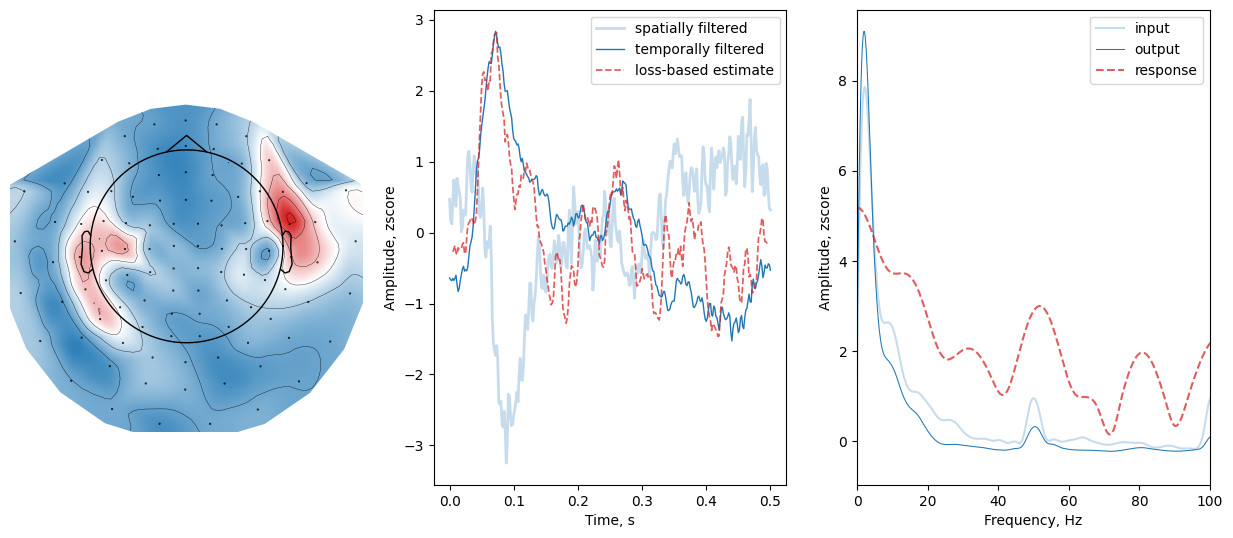

In [15]:
fig = interpreter.plot_branch(0)

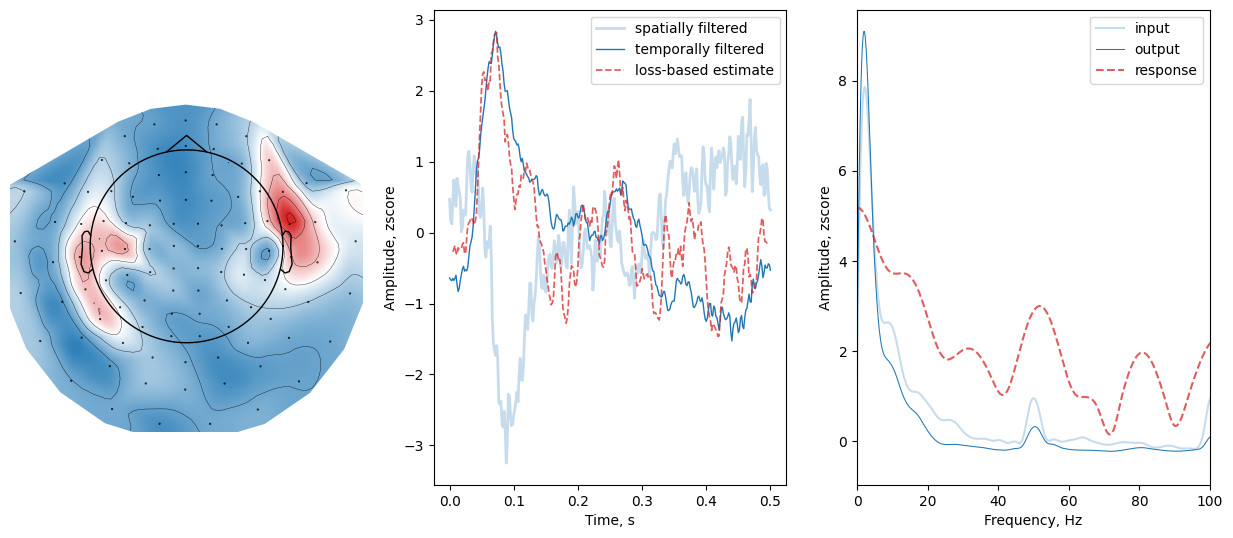

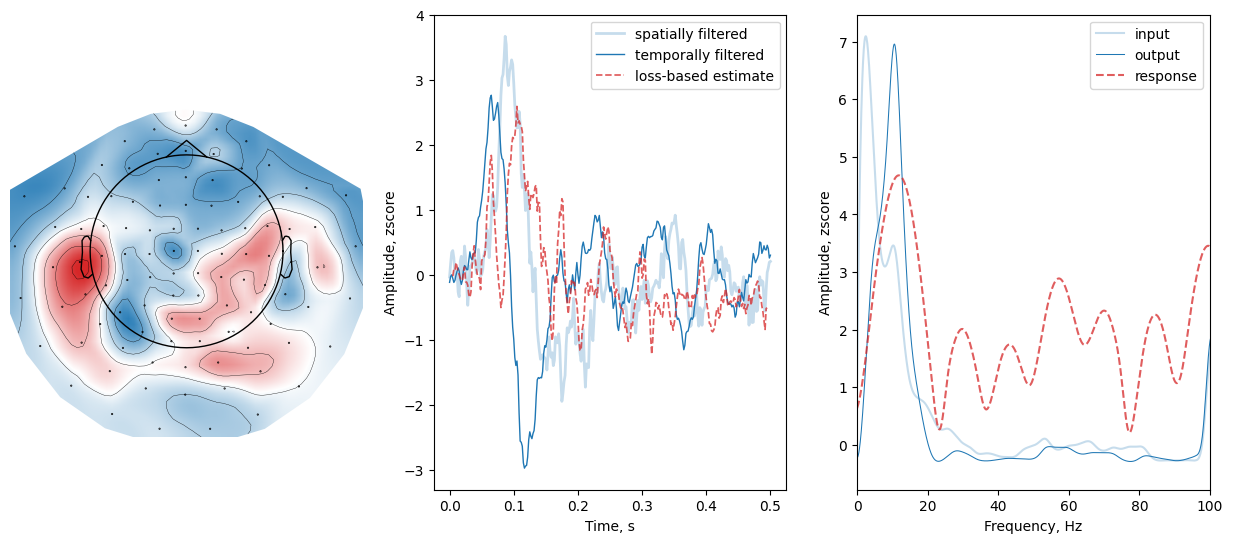

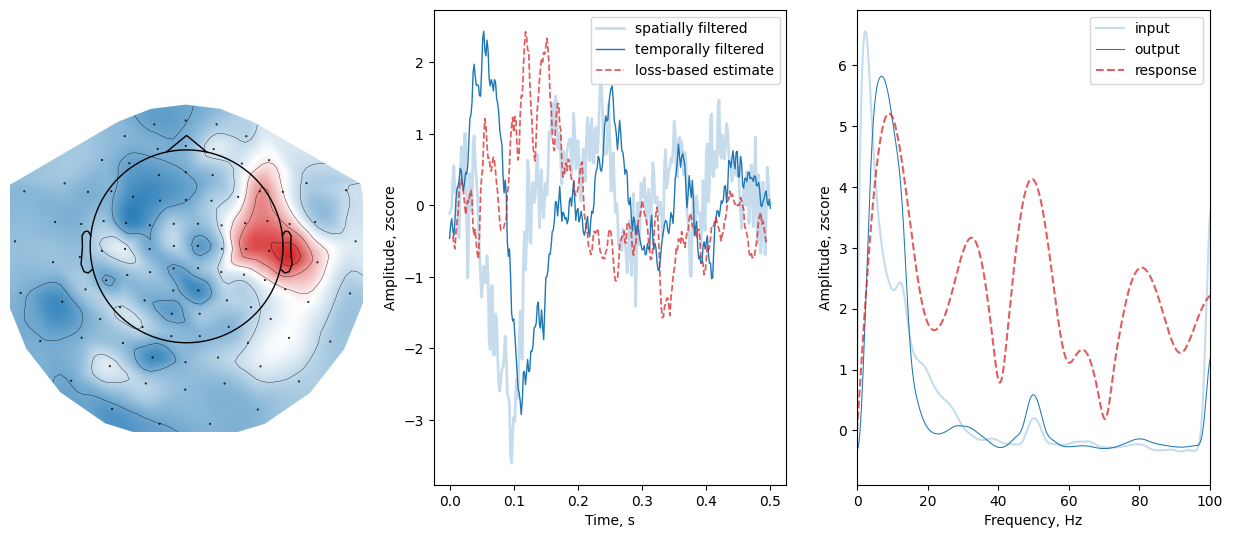

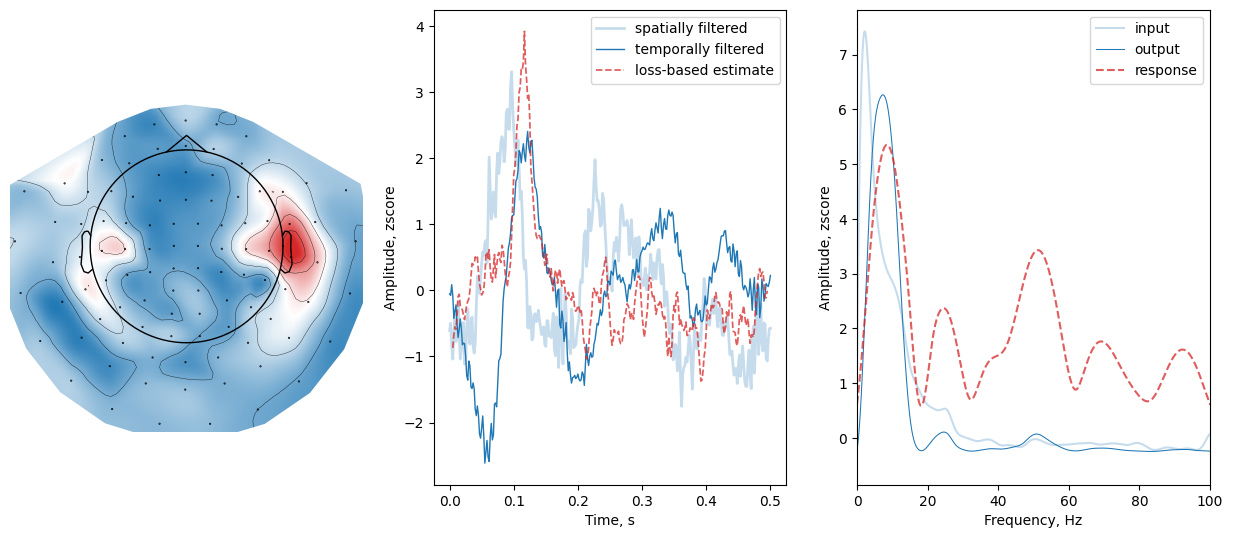

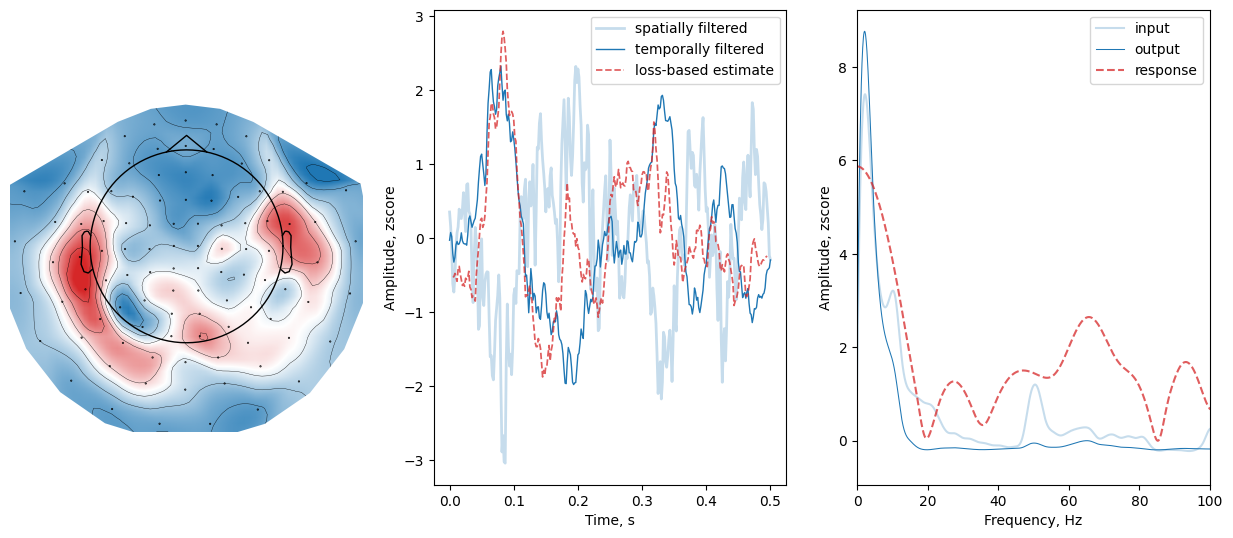

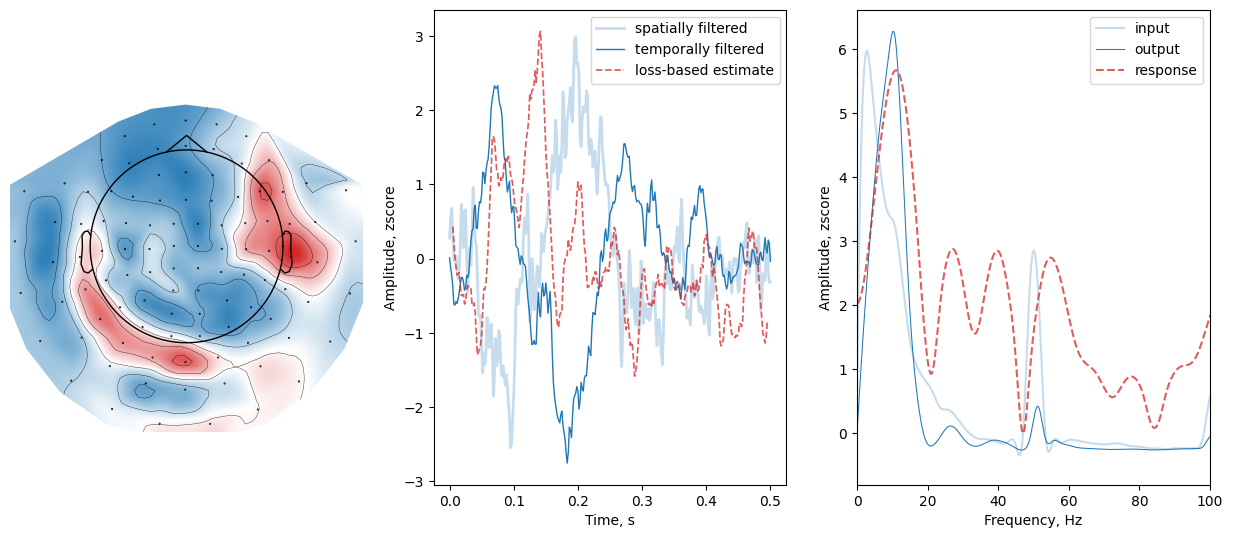

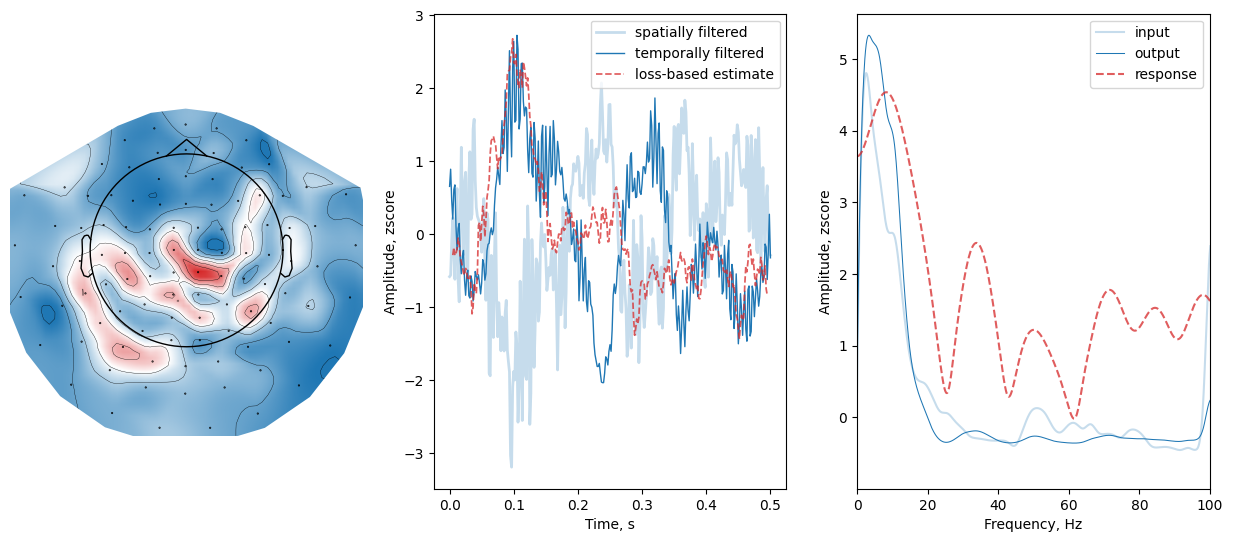

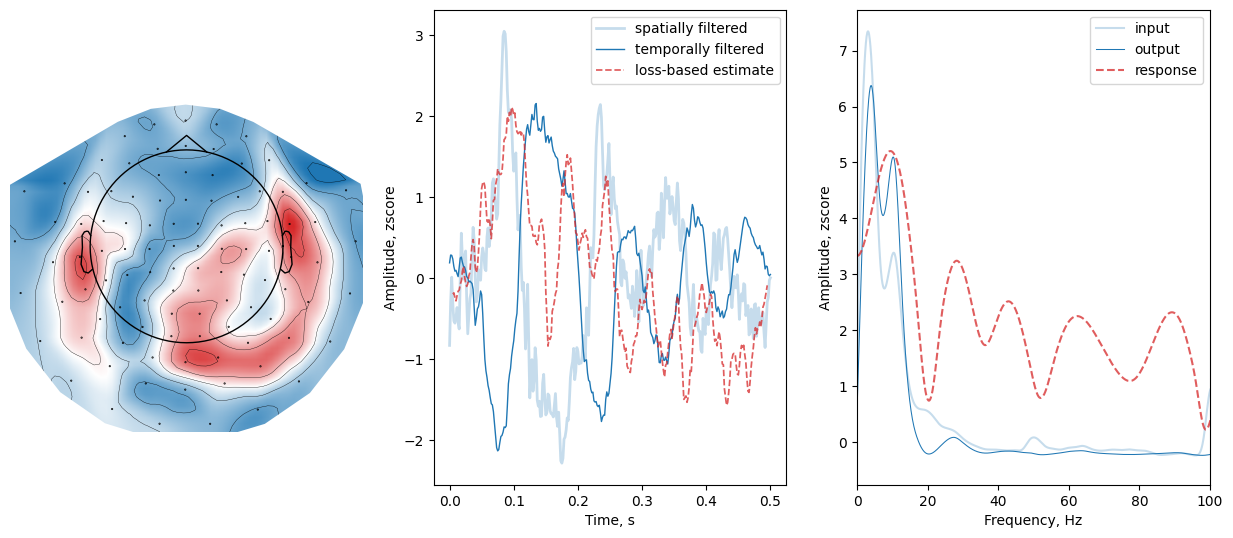

In [16]:
for i in range(8):
    fig = interpreter.plot_branch(i)
    plt.show()

In [43]:
datetime.now().weekday()

0